**1. downsample to daily, `one obversation`daily**

**2. calculate the `daily return`**

**3. `feature`: 昨天的return， `target`: 下一天的return**

**4. `labeling` y>0 为1 y<0 为-1**

In [63]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

In [44]:
import os
os.chdir('/mnt/c/Users/HansonMei/OneDrive - CUHK-Shenzhen/深高金/Courses/Third Semester_C/Financial Data Driven Quant/BlackBoard/code/lec4')
!pwd

/mnt/c/Users/HansonMei/OneDrive - CUHK-Shenzhen/深高金/Courses/Third Semester_C/Financial Data Driven Quant/BlackBoard/code/lec4


In [45]:
def cprint(df):
    if not isinstance(df, (pd.DataFrame)):
        try:
            df = df.to_frame()
        except:
            raise ValueError('object cannot be coerced to df')

    print('-'*79)
    print('dataframe information')
    print('-'*79)
    print(df.tail(5))
    print('-'*50)
    print(df.info())
    print('-'*79)
    print()

In [46]:
def read_kibot_ticks(fp):
    # read tick data from http://www.kibot.com/support.aspx#data_format
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df

data_dir = 'data/IVE_tickbidask.txt'   
#infp = PurePath(data_dir/'raw'/'IVE_tickbidask.txt')
# infp = PurePath(data_dir+'/raw/IVE_tickbidask.txt')
raw_df = read_kibot_ticks(data_dir)

In [47]:
cprint(raw_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask  size     v        dv
dates                                                            
2019-10-10 15:59:59  117.41  117.39  117.41   300   300   35223.0
2019-10-10 15:59:59  117.40  117.40  117.44   100   100   11740.0
2019-10-10 16:00:00  117.40  117.40  117.46  4228  4228  496367.2
2019-10-10 16:10:00  117.40  116.96  118.49     0     0       0.0
2019-10-10 18:30:00  117.40  115.60  119.36     0     0       0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1668660 entries, 2009-09-28 09:30:00 to 2019-10-10 18:30:00
Data columns (total 6 columns):
price    1668660 non-null float64
bid      1668660 non-null float64
ask      1668660 non-null float64
size     1668660 non-null int64
v        1668660 non-null 

In [81]:
raw_df.head(5)# v:volume dv: dollar volume

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00


In [83]:
raw_df['timestamp'] = raw_df.index

In [84]:
# for i in ['year','month','day']:
#     df[i] = eval(f"df['timestamp'].dt.{i}")

In [85]:
raw_df['date'] = raw_df.timestamp.dt.date

In [86]:
df = raw_df.resample('1D').aggregate({"price":"last","size":"sum"}) # resample('1D'): resample as one day

In [87]:
df.dropna(inplace=True)

In [88]:
df['ret'] = df['price'].pct_change()

In [89]:
df['yes_ret'] = df['ret'].shift(1)

In [90]:
df['labeled_y'] = df.ret.map(lambda x: 1 if x > 0 else -1)

In [92]:
df.dropna(inplace=True)

In [97]:
df.drop(columns='price', inplace=True)
df.head()

,size,ret,yes_ret,labeled_y
dates,,,,
2009-09-30,280153,-0.003884,-0.000970,-1
2009-10-01,629083,-0.018978,-0.003884,-1
2009-10-02,516429,-0.016030,-0.018978,-1
2009-10-05,286111,0.019871,-0.016030,1
2009-10-06,219542,0.012005,0.019871,1


In [105]:
train, test = df.iloc[:int(df.shape[0]*0.8)], df.iloc[int(df.shape[0]*0.8):]
train.shape, test.shape

((2020, 4), (505, 4))

In [108]:
X_train, X_test, y_train, y_test = train[['yes_ret','size']], test[['yes_ret','size']], train['labeled_y'], test['labeled_y']

In [112]:
# model init
clf = RandomForestClassifier(n_estimators=100)

# model fit
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [110]:
cross_val_score(clf, X=df[['size', 'yes_ret']], y=df['labeled_y'], cv=5, scoring='r2')

array([-0.93184389, -1.05904349, -0.95106759, -1.04336189, -1.1311626 ])

In [115]:
from sklearn.metrics import roc_curve, auc, f1_score, r2_score

In [116]:
# predict
y_pred = clf.predict(X_test)
f1_score(y_pred, y_test)

0.5483304042179261

In [122]:
y_score = clf.predict_proba(X_test)[:, 1]
fpr,tpr,threshold = roc_curve(y_test, y_score)

<Figure size 432x288 with 0 Axes>

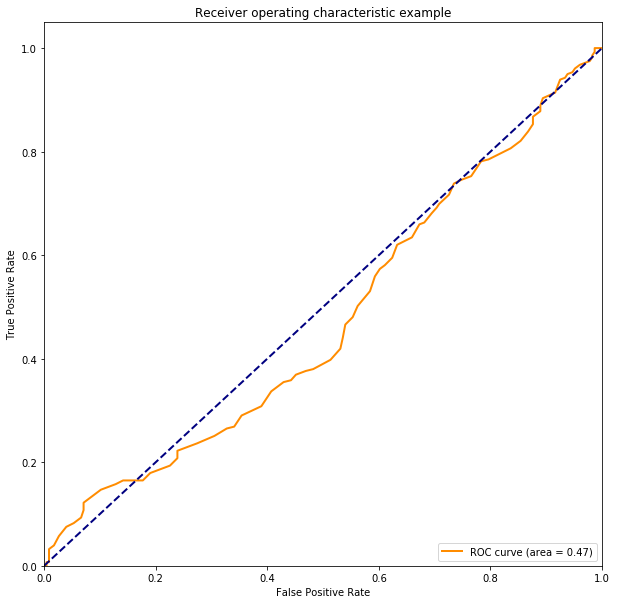

In [126]:
import matplotlib.pyplot as plt
roc_auc = auc(fpr,tpr) ###计算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# y_test['proba'] = rf_probs
# def roc_curve_(result):
#     result.columns = ['target', 'proba']
#     fpr,tpr,threshold = roc_curve(result['target'],result['proba']) ###计算真正率和假正率  
#     roc_auc = auc(fpr,tpr) ###计算auc的值  
#     plt.figure()  
#     lw = 2  
#     plt.figure(figsize=(10,8))  
#     plt.plot(fpr, tpr, color='darkorange',  
#              lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)   
#     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
#     plt.xlim([0.0, 1.0])  
#     plt.ylim([0.0, 1.05])  
#     plt.xlabel('False Positive Rate')  
#     plt.ylabel('True Positive Rate')  
#     plt.title('Roc Curve')  
#     plt.legend(loc="lower right")  
#     plt.show() 